In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784
train_epoch = 500
batch_size = 128
lr = 0.0002

In [ ]:
import os

def read_sentences_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split text into sentences (simple split by period, adjust as necessary for your data)
    sentences = text.split('.')
    # Remove any leading/trailing whitespace and filter out empty strings
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

def read_sentences_from_folder(root_folder):
    all_sentences = []
    for foldername in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, foldername)
        if os.path.isdir(folder_path):
            label_file_path = os.path.join(folder_path, 'label.txt')
            if os.path.exists(label_file_path):
                sentences = read_sentences_from_file(label_file_path)
                all_sentences.extend(sentences)
    return all_sentences

# Specify your root folder path here
root_folder = '/content/drive/MyDrive/Test_out/Feature/Train'

# Get all sentences from the folder
all_sentences = read_sentences_from_folder(root_folder)

# Print all sentences or do something else with them
for sentence in all_sentences:
    print(sentence)


am tag im norden frischer bis starker wind dort sowie auf den bergen sind sturmböen mit dabei
aber in bayern sind noch einige gewitter unterwegs und deswegen gab es auch dort nochmal die unwetterwarnung des deutschen wetterdienstes hauptsächlich vor starken dauerregen und zum teil auch vor hagel
deutschlandweit bleibt es trocken
zunächst bleibt es noch verhältnismäßig mild nächste woche wird es dann kühler
von westen ziehen am nachmittag neue wolken ins land und gebietsweise fällt regen
am tag drei grad im berchtesgadener land und elf grad am niederrhein
aber südlich des mains bleibt es meist trocken wo bis zum späten nachmittag und vor allen dingen an den alpen scheint zeitweise die sonne
besonders in den alpenregionen besteht hochwasser und überschwemmungsgefahr vor erdrutschen wird gewarnt
die sonne kommt bruzzelt diese nebelfelder weg
auch am sonntag viele wolken vor allem im osten und süden schneit es noch kräftiger sonst lässt der schneefall allmählich nach
am sonntag lässt zumin

In [ ]:
print(len(all_sentences))

12


In [ ]:
import os
import pandas as pd

# Load the text vocabulary CSV file into a DataFrame
csv_path = '/content/drive/MyDrive/Test_out/Feature/text_vocabulary.csv'
vocabulary_df = pd.read_csv(csv_path)



In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load your DataFrame (replace 'csv_path' with the actual path)
csv_path = '/content/drive/MyDrive/Test_out/Feature/text_vocabulary.csv'
vocabulary_df = pd.read_csv(csv_path)

# Initialize LabelEncoder
le = LabelEncoder()

# Encode the 'text' column and store it in a new column 'text_encoded'
vocabulary_df['text_encoded'] = le.fit_transform(vocabulary_df['text'])

# Display the DataFrame with encoded labels
print(vocabulary_df.head())

                                                text  text_encoded
0  aber bei sonne werden durchaus nochmal sechzeh...            58
1  morgen im norden und nordwesten einige wolken ...          4939
2  und nun die wettervorhersage für morgen donner...          6108
3  die temperaturen meist so zwischen zehn und vi...          2791
4  das tief das heute im norden deutschlands für ...          2163


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load your DataFrame (replace 'csv_path' with the actual path)
csv_path = '/content/drive/MyDrive/Test_out/Feature/text_vocabulary.csv'
vocabulary_df = pd.read_csv(csv_path)

# Initialize LabelEncoder
le = LabelEncoder()

# Encode the 'text' column and store it in a new column 'text_encoded'
vocabulary_df['text_encoded'] = le.fit_transform(vocabulary_df['text'])

# Save the DataFrame with encoded labels to a new CSV file
output_csv_path = '/content/drive/MyDrive/Test_out/Feature/text_vocabulary_encoded.csv'  # Choose a path for the new file
vocabulary_df.to_csv(output_csv_path, index=False)

print(f"DataFrame with encoded labels saved to: {output_csv_path}")

DataFrame with encoded labels saved to: /content/drive/MyDrive/Test_out/Feature/text_vocabulary_encoded.csv


In [ ]:
count = 0
for sentence in all_sentences:
    if sentence in vocabulary_df['text'].values:
        count += 1

print(f"Number of sentences in vocabulary_df: {count}")

Number of sentences in vocabulary_df: 12


In [ ]:
# Assuming 'vocabulary_df' and 'le' are available from previous cells
sentence_to_encoding = dict(zip(vocabulary_df['text'], vocabulary_df['text_encoded']))

for sentence in all_sentences:
    if sentence in sentence_to_encoding:
        encoded_value = sentence_to_encoding[sentence]
        print(f"Sentence: {sentence}, Encoded Value: {encoded_value}")

Sentence: am tag im norden frischer bis starker wind dort sowie auf den bergen sind sturmböen mit dabei, Encoded Value: 1140
Sentence: aber in bayern sind noch einige gewitter unterwegs und deswegen gab es auch dort nochmal die unwetterwarnung des deutschen wetterdienstes hauptsächlich vor starken dauerregen und zum teil auch vor hagel, Encoded Value: 130
Sentence: deutschlandweit bleibt es trocken, Encoded Value: 2600
Sentence: zunächst bleibt es noch verhältnismäßig mild nächste woche wird es dann kühler, Encoded Value: 6759
Sentence: von westen ziehen am nachmittag neue wolken ins land und gebietsweise fällt regen, Encoded Value: 6574
Sentence: am tag drei grad im berchtesgadener land und elf grad am niederrhein, Encoded Value: 1073
Sentence: aber südlich des mains bleibt es meist trocken wo bis zum späten nachmittag und vor allen dingen an den alpen scheint zeitweise die sonne, Encoded Value: 162
Sentence: besonders in den alpenregionen besteht hochwasser und überschwemmungsgefahr 

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None, encoded_sentences=None): # Renamed parameter to avoid shadowing
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        # Initialize encoded_labels as an empty list if not provided
        self.encoded_labels = encoded_sentences if encoded_sentences is not None else []  # Renamed attribute to 'encoded_labels'
        self.load_data()

    def load_data(self):
        for subdir in ['Train']:
            subdir_path = os.path.join(self.root_dir, subdir)
            for folder in os.listdir(subdir_path):
                folder_path = os.path.join(subdir_path, folder)
                label_path = os.path.join(folder_path, 'label.txt')
                if os.path.isdir(folder_path) and os.path.exists(label_path):
                    with open(label_path, 'r') as file:
                        label = file.read().strip()
                    for img_file in os.listdir(folder_path):
                        if img_file.endswith('.jpg') or img_file.endswith('.png'):
                            img_path = os.path.join(folder_path, img_file)
                            self.data.append((img_path, label))
                            # Assuming you have a way to encode labels, append the encoded label here
                            # Replace 'encode_label(label)' with your actual encoding logic
                            self.encoded_labels.append(self.encode_label(label))  # Use a method to encode labels

    def encode_label(self, label): # Placeholder for your encoding logic
        # Replace this with your actual label encoding logic
        return label

    def __len__(self):
        return len(self.encoded_labels)

    def __getitem__(self, idx):
        img_path, _ = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        encoded_label = self.encoded_labels[idx]
        return image, encoded_label

# ... (rest of the code remains the same)

# Data transformations
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Placeholder for encoded labels, replace with your actual encoded labels
encoded_sentences = []  # Example: You need to populate this list with encoded labels

# Load datasets
# Load datasets
train_dataset = SignLanguageDataset(root_dir='/content/drive/MyDrive/Test_out/Feature',
                                    transform=transform,
                                    encoded_sentences=encoded_sentences) # Use 'encoded_sentences' instead of 'encoded_value'

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None, sentence_to_encoding=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.encoded_labels = []
        self.sentence_to_encoding = sentence_to_encoding
        self.load_data()

    def load_data(self):
        for subdir in ['Train']:
            subdir_path = os.path.join(self.root_dir, subdir)
            for folder in os.listdir(subdir_path):
                folder_path = os.path.join(subdir_path, folder)
                label_path = os.path.join(folder_path, 'label.txt')
                if os.path.isdir(folder_path) and os.path.exists(label_path):
                    with open(label_path, 'r') as file:
                        label = file.read().strip()
                    for img_file in os.listdir(folder_path):
                        if img_file.endswith('.jpg') or img_file.endswith('.png'):
                            img_path = os.path.join(folder_path, img_file)
                            self.data.append((img_path, label))
                            self.encoded_labels.append(self.encode_label(label))

    def encode_label(self, label):
        if self.sentence_to_encoding and label in self.sentence_to_encoding:
            return self.sentence_to_encoding[label]
        else:
            return -1

    def __len__(self):
        return len(self.encoded_labels)

    def __getitem__(self, idx):
        img_path, _ = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        encoded_label = self.encoded_labels[idx]
        return image, encoded_label

# Data transformations
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# Assuming 'sentence_to_encoding' is available from previous cells
# Load datasets
train_dataset = SignLanguageDataset(root_dir='/content/drive/MyDrive/Test_out/Feature',
                                    transform=transform,
                                    sentence_to_encoding=sentence_to_encoding)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True) # Removed 'train', 'download', and 'transform'

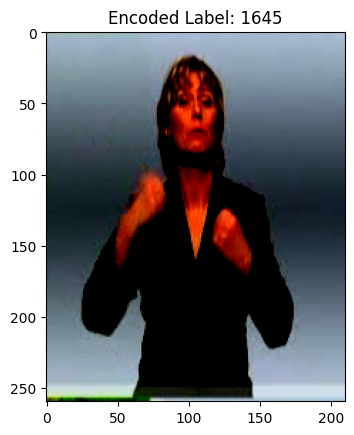

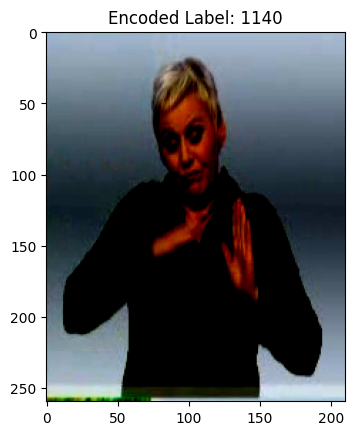

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Choose the number of samples to display
num_samples_to_display = min(20, len(train_loader))

# Use the DataLoader in a loop to get batches of data
dataiter = iter(train_loader)
for i in range(num_samples_to_display):
    # Get a batch of data
    images, labels = next(dataiter)

    # Assuming you want to display the first image in the batch
    image = images[0]
    label = labels[0]

    # Display the image
    plt.figure()  # Create a new figure for each image
    plt.imshow(image.permute(1, 2, 0))  # Rearrange dimensions and display
    plt.title(f"Encoded Label: {label}")  # Set the title with the encoded label
    plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class = 12):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 1024)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.tanh(self.fc4(x))

        return x


In [ ]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class=12):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 256)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.fc4(x))

        return x


In [ ]:
# Determine if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fixed_z_ = torch.randn((5 * 5, 100))    # fixed noise
fixed_z_ = Variable(fixed_z_.to(device), volatile=True) # Move tensor to device

<ipython-input-18-7fc7976386c7>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  fixed_z_ = Variable(fixed_z_.to(device), volatile=True) # Move tensor to device


In [ ]:

def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100))
    z_ = Variable(z_.cuda(), volatile=True)

    G.eval()
    if isFix:
        test_images = G(fixed_z_)
    else:
        test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


In [ ]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pickle
import imageio
import numpy as np
import cv2  # OpenCV for contrast enhancement
from torch.cuda.amp import GradScaler, autocast

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming generator and discriminator are defined elsewhere
# Initialize models and move them to the correct device
G = generator(input_size=100, n_class=3*260*210).to(device)
D = discriminator(input_size=3*260*210, n_class=1).to(device)

# BCEWithLogitsLoss combines sigmoid and binary cross entropy
BCE_loss = nn.BCEWithLogitsLoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

# Mixed Precision Scaler
scaler = GradScaler()

# Results save folder
results_dir = '/content/drive/MyDrive/Test_out/Feature'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(os.path.join(results_dir, 'SLR_GAN_results'), exist_ok=True)
os.makedirs(os.path.join(results_dir, 'SLR_results/Fixed_results'), exist_ok=True)

train_hist = {'D_losses': [], 'G_losses': []}

for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    for x_, _ in train_loader:
        x_ = (x_ - 0.5) / 0.5  # Normalize to [-1, 1]
        x_ = x_.to(device)

        # Train discriminator D
         # Reshape to match the actual input size of D
         # Reshape to match the actual input size of D
         # Reshape to match the actual input size of D
        D.zero_grad()
        x_ = x_.view(-1, 3 * 260 * 210)
        mini_batch = x_.size(0)
        y_real_ = torch.ones(mini_batch, 1, device=device)
        y_fake_ = torch.zeros(mini_batch, 1, device=device)

        x_ = Variable(x_)
        D_result = D(x_)
        D_real_loss = BCE_loss(D_result, y_real_)
        D_real_score = torch.sigmoid(D_result)

        z_ = torch.randn((mini_batch, 100), device=device)
        G_result = G(z_)
        G_result = G_result.view(-1, 3*260*210) # Reshape to match the actual input size of D
        D_result = D(G_result)
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = torch.sigmoid(D_result)

        D_train_loss = D_real_loss + D_fake_loss

        # Mixed precision training
        scaler.scale(D_train_loss).backward()
        scaler.step(D_optimizer)
        scaler.update()

        D_losses.append(D_train_loss.item())

        # Train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100), device=device)
        y_ = torch.ones(mini_batch, 1, device=device)

        with autocast():
            G_result = G(z_)
            G_result = G_result.view(-1, 3 * 260 * 210)  # Reshape the generator output as well
            D_result = D(G_result)
            G_train_loss = BCE_loss(D_result, y_)

        # The following two lines were incorrectly indented
        scaler.scale(G_train_loss).backward()
        scaler.step(G_optimizer)
        scaler.update()

        G_losses.append(G_train_loss.item())

    print(f'Epoch [{epoch + 1}/{train_epoch}]: Loss_D: {np.mean(D_losses):.3f}, Loss_G: {np.mean(G_losses):.3f}')

    # Save generated images
    try:
        with torch.no_grad():
            fixed_z = torch.randn(25, 100, device=device)
            generated_images = G(fixed_z)
            generated_images = generated_images.view(-1, 3, 260, 210).cpu().numpy()

            # Normalize and enhance contrast
            generated_images = (generated_images - np.min(generated_images)) / (np.max(generated_images) - np.min(generated_images))
            generated_images = (generated_images * 255).astype(np.uint8)

            # Apply adaptive histogram equalization
            enhanced_images = []
            for img in generated_images:
                img = img.transpose(1, 2, 0)
                img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(img_lab)
                clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                cl = clahe.apply(l)
                img_lab = cv2.merge((cl, a, b))
                img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
                enhanced_images.append(img.transpose(2, 0, 1))
            enhanced_images = np.array(enhanced_images)

            # Create grid
            grid_size = int(np.sqrt(enhanced_images.shape[0]))
            grid = np.zeros((grid_size * 260, grid_size * 210, 3), dtype=np.uint8)
            for i in range(grid_size):
                for j in range(grid_size):
                    grid[i * 260:(i + 1) * 260, j * 210:(j + 1) * 210, :] = enhanced_images[i * grid_size + j].transpose(1, 2, 0)

            file_name = f'SLR_GAN_{epoch + 1}.png'
            imageio.imwrite(os.path.join(results_dir, 'SLR_results/Fixed_results', file_name), grid)
            print(f'Successfully saved image for epoch {epoch + 1}')
    except Exception as e:
        print(f"Error saving images for epoch {epoch + 1}: {e}")

    train_hist['D_losses'].append(np.mean(D_losses))
    train_hist['G_losses'].append(np.mean(G_losses))

print("Training finished! Saving training results...")
torch.save(G.state_dict(), os.path.join(results_dir, "SLR_GAN_results/generator_param.pkl"))
torch.save(D.state_dict(), os.path.join(results_dir, "SLR_GAN_results/discriminator_param.pkl"))
with open(os.path.join(results_dir, 'SLR_GAN_results/train_hist.pkl'), 'wb') as f:
    pickle.dump(train_hist, f)

# Check if the images exist before creating a GIF
images = []
for e in range(train_epoch):
    img_name = os.path.join(results_dir, f'SLR_results/Fixed_results/SLR_GAN_{e + 1}.png')
    if os.path.exists(img_name):
        images.append(imageio.imread(img_name))
    else:
        print(f"Warning: Image not found at {img_name}")

if images:
    imageio.mimsave(os.path.join(results_dir, 'SLR_GAN_results/generation_animation.gif'), images, fps=5)
else:
    print("No images found to create GIF.")


Epoch [1/500]: Loss_D: 1.340, Loss_G: 0.511
Successfully saved image for epoch 1
Epoch [2/500]: Loss_D: 1.624, Loss_G: 0.315
Successfully saved image for epoch 2
Epoch [3/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 3
Epoch [4/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 4
Epoch [5/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 5
Epoch [6/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 6
Epoch [7/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 7
Epoch [8/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 8
Epoch [9/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 9
Epoch [10/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 10
Epoch [11/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 11
Epoch [12/500]: Loss_D: 1.627, Loss_G: 0.313
Successfully saved image for epoch 12
Epoch [13/500]: Loss_D

<ipython-input-21-dcf990e39965>:148: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))
